In [2]:
datapath1 = 'Data/BindingDB_All_Mol.csv'
datapath2 = 'Data/BindingDB_All_Seq.csv'
modelpath = 'saves/Models/model699.pkl'
RANDOMSEED = 42

import pandas as pd
import gc

print("Start Reading Data")
data1 = pd.read_csv(datapath1, low_memory=False)
print('data1 done')
data2 = pd.read_csv(datapath2, low_memory=False)
print('data2 done')

import numpy as np
data = pd.concat([data1,data2], axis = 1).iloc[:,3:].astype(np.float32).dropna()

del data1
del data2
gc.collect()

print('data1&data2 removed')

data["Ki (log10)"] = data["Ki (log10)"].map(lambda x : x if x > -8 else None)
data = data.dropna()

Start Reading Data
data1 done
data2 done
data1&data2 removed


In [16]:
import numpy as np
import torch
from torch.utils.data import DataLoader,TensorDataset,SequentialSampler,RandomSampler
from torch import tensor

import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset,SequentialSampler,RandomSampler
from torch import tensor, nn
import torch

train_data, internal_test = train_test_split(data,test_size=0.2, random_state=RANDOMSEED)

train_data, test_data = train_test_split(train_data,test_size=0.1, random_state=RANDOMSEED)

# train
train_seq = tensor(np.array(train_data.iloc[:,301:])).unsqueeze(dim=1).to(torch.float32)
train_mol = tensor(np.array(train_data.iloc[:,1:301])).unsqueeze(dim=1).to(torch.float32)
train_Ki = tensor(np.array(train_data.iloc[:,0]))

trainDataset = TensorDataset(train_mol,train_seq,train_Ki)
trainDataLoader = DataLoader(trainDataset, batch_size=1024)

In [4]:
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
import torch

# block ------------------------------------------------------------------------
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, use_conv1=False, strides=1):
        super().__init__()
        
        self.process = nn.Sequential (
            nn.Conv1d(in_channels, out_channels, 3, stride=strides, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Conv1d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm1d(out_channels)
        )
        
        if use_conv1:
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv1 = None
        
    def forward(self, x):
        left = self.process(x)
        right = x if self.conv1 is None else self.conv1(x)
        
        return F.relu(left + right)

# cnnNet ------------------------------------------------------------------------
class cnnNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pre = nn.Sequential (
            nn.Conv1d(1, 32, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.MaxPool1d(2)
        )
        
        self.layer1 = self._make_layer(32, 16, 2)
        
        
    def _make_layer(self, in_channels, out_channels, block_num, strides=1):

        layers = [Block(in_channels, out_channels, use_conv1=True, strides=strides)] # build the first layer with conv1
        
        for i in range(block_num):
            layers.append(Block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.pre(x)
        x = self.layer1(x)
        
        return x

torch.cuda.empty_cache()

# mainNet ------------------------------------------------------------------------
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mol_cnn = cnnNet()
        self.seq_cnn = cnnNet()
        
        self.pooling = nn.AvgPool1d(5, stride = 3)
        
        self.lstm = nn.LSTM(538, 64, num_layers=2, batch_first=True, bidirectional=True)
        
        self.linear = nn.Sequential (
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 32),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(p=0.2),
            
#             nn.Linear(128, 32),
#             nn.BatchNorm1d(32),
            #nn.ReLU(),
#             nn.Dropout(p=0.5),
            
            nn.Linear(32, 1),
        )

    def forward(self, mol, seq):
        mol = self.mol_cnn(mol)
        seq = self.seq_cnn(seq)
        
        # put data into lstm        
        x = torch.cat((mol,seq),2)
        x = self.pooling(x)
        x,_ = self.lstm(x)
        
        # fully connect layer
        x = x.flatten(1)
        x = self.linear(x)
        
        return x.flatten()

# initialize weight
def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [17]:
model = torch.load(modelpath)

model = model.eval()

In [14]:
model

Net(
  (mol_cnn): cnnNet(
    (pre): Sequential(
      (0): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Block(
        (process): Sequential(
          (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.3, inplace=False)
          (4): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
      )
      (1): Block(
        (process): Seq

In [13]:
paras = list(model.parameters())
for num,para in enumerate(paras):
    print('number:',num)
    print(para.shape)
    print('_____________________________')

number: 0
torch.Size([32, 1, 7])
_____________________________
number: 1
torch.Size([32])
_____________________________
number: 2
torch.Size([32])
_____________________________
number: 3
torch.Size([16, 32, 3])
_____________________________
number: 4
torch.Size([16])
_____________________________
number: 5
torch.Size([16])
_____________________________
number: 6
torch.Size([16])
_____________________________
number: 7
torch.Size([16, 16, 3])
_____________________________
number: 8
torch.Size([16])
_____________________________
number: 9
torch.Size([16])
_____________________________
number: 10
torch.Size([16])
_____________________________
number: 11
torch.Size([16, 32, 1])
_____________________________
number: 12
torch.Size([16])
_____________________________
number: 13
torch.Size([16, 16, 3])
_____________________________
number: 14
torch.Size([16])
_____________________________
number: 15
torch.Size([16])
_____________________________
number: 16
torch.Size([16])
____________________

In [18]:
from pytorch_lightning.metrics.functional import r2score
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

loss_fn = nn.MSELoss()

re = np.array([])
true = np.array([])

for batch in tqdm(dataloader):
        input_mols, input_seqs, labels = tuple(t.to("cuda") for t in batch)
        
        with torch.no_grad():
            logits = model(input_mols, input_seqs)
        
        re = np.append(re,np.array(logits.to("cpu")))
        true = np.append(true,np.array(labels.to("cpu")))

re

  0%|          | 0/244 [00:00<?, ?it/s]

array([-0.78898865, -0.12171857, -0.75321352, ..., -3.13511443,
       -3.06713915, -2.96263695])

In [20]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from math import sqrt

print("MSE: \t\t" + str(mse(true,re)))
print("MAE: \t\t" + str(mae(true,re)))
print("r2: \t\t" + str(r2(true,re)))
print("RMSE: \t\t" + str(sqrt(mse(true,re))))
print("r: \t\t" + str(sqrt(r2(true,re))))

MSE: 		0.4611984740226748
MAE: 		0.5014466114035545
r2: 		0.7917221894354447
RMSE: 		0.6791159503521286
r: 		0.8897877215580381


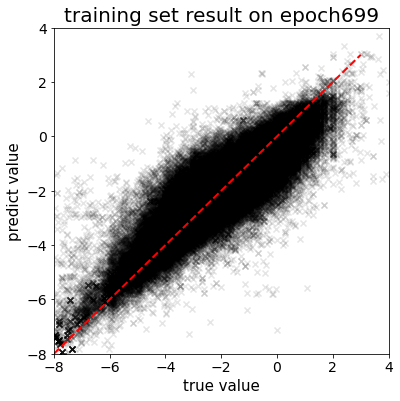

In [21]:
from matplotlib import pyplot as plt


plt.figure(figsize=(6,6))
plt.xlabel("true value",fontsize=15)
plt.ylabel("predict value",fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-8,4)
plt.ylim(-8,4)
plt.scatter(true,re,alpha=0.1,marker="x",color="Black")
plt.plot(range(-8,4),range(-8,4),color="r",linestyle="--",linewidth=2)
plt.title("training set result on epoch699",fontsize=20)
plt.savefig("model699 - innertest.svg")